# Quora Insincere Questions Classification

![logo](images/quora.jpg)


## Objectives

Detect toxic content to improve online conversations

*Source : Kaggle Challenge* : [Quora insincere questions](https://www.kaggle.com/c/quora-insincere-questions-classification)


## Context

Quora is a popular website where anyone can ask and/or answer a question. There are more than 100 millions unique visitors per month.

Like any other forum, Quora is facing a problem: toxic questions and comments.

As you can imagine, Quora teams cannot check all of the Q&A by hand. So they decided to ask the data science community to help them to perform automatically insincere questions classification.


## Dataset 

All important files used for my project saved [here](https://drive.google.com/drive/u/0/folders/16ISw88BaAWbCt8d0RZtgZ6biLszrtatS)

📥 The Kaggle dataset is quite heavy and it may be too difficult for my laptop to perform the computations. Therefore, I provide **the train dataset** (to be sampled) and also **light word embeddings**, which I download [here](https://www.kaggle.com/c/quora-insincere-questions-classification/data).

Quora provided a dataset of questions with a label, and the features are the following:

- `qid`: a unique identifier for each question, an hexadecimal number
- `question_text`: the text of the question
- `target`: either 1 (for insincere question) or 0

🔦 In this project, the metric used for performance evaluation is the **F1-score**.

<h2> Import

In [1]:
#System library
import os

#Data manipulation
import pandas as pd, numpy as np
from sklearn.utils import resample                                                #Select sample on dataset

#Data storage
import pickle
from joblib import dump, load                                                     #Joblib is more persistent than Pickle for large data, in particular large numpy arrays.

#Data visualization
import matplotlib.pyplot as plt, seaborn as sns

#Text Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import operator

#Data Preprocessing
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Supervised Machine Learning Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Metrics computed for Classification
from sklearn.metrics import classification_report, f1_score

I load Quora questions dataset in a pandas dataframe :

In [2]:
#Define dataset path :
filepath = os.path.join('data','quora_train.csv')

#Load csv file with pandas dataframe
quora_questions = pd.read_csv(filepath)

In [3]:
#See dataset shape
quora_questions.shape

(1306122, 3)

<h2> 1. Sample dataset : 10 000 rows

First, I sample the dataset to 10.000 lines to can use it on my computer : I use `resample` function from `scikit-learn`.

In [4]:
#Sample Quora dataset to 10 000 rows
quora_questions = resample(quora_questions, n_samples=10000, random_state=0)

In [5]:
#See dataset shape
quora_questions.shape

(10000, 3)

<h2> 2. Exploration Data analysis

<h3> 2.1 Data Exploration

In [6]:
#Show the first five rows of data
quora_questions.head()

,qid,question_text,target
305711,3be0cfa79beb7e5f606b,"Who would win, SSB Goku (ToP) vs Base Goku (SD...",0
117952,1716ecee485d6cd0a819,Are there any organizational skills classes or...,0
963395,bcc372d77a2e615351b6,If an abuser married a person he/she can’t abu...,0
152315,1dcc547fdc41b1a554a0,Why didn't they accept me in the Conservatoriu...,0
359783,4683c11a002d6fba5630,What is the media role in ending drunk driving?,0


As we can see, the dataset has **three columns** as follows :
- `qid`: a unique identifier for each question, an hexadecimal number
- `question_text`: the text of the question
- `target`: either 1 (for insincere question) or 0

It contains **string** but `target` is **numerical values (discrete)** : It's a **Supervised Machine Learning** case (Classification).

In [7]:
quora_questions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 305711 to 219610
Data columns (total 3 columns):
qid              10000 non-null object
question_text    10000 non-null object
target           10000 non-null int64
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


Next, I display some **statistical summaries** of `target` below : I constat that `target` 0 corresponding to sincere questions is majority.

In [8]:
#Statistical summaries of `target`
quora_questions.describe()

,target
count,10000.000000
mean,0.064400
std,0.245476
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<h3> 2.2 Data Cleaning

Some relevant informations with **Data Cleaning** are :
- **No null values**
- **45 duplicates**

In [9]:
#Number of null values
quora_questions.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

I drop duplicates in my dataframe because they are useless :

In [10]:
#Number of duplicates
quora_questions.duplicated().sum()

45

In [11]:
#Drop duplicates
quora_questions.drop_duplicates(inplace=True)

In [12]:
#Number of duplicates
quora_questions.duplicated().sum()

0

In [13]:
quora_questions.shape

(9955, 3)

<h4> Data save

In [14]:
#Define file path :
filepath_quora_cleaned = os.path.join('data', 'quora_questions_cleaned.pkl')

#Save quora dataset with pickle:
quora_questions.to_pickle(filepath_quora_cleaned)

In [22]:
#Define file path :
filepath_quora_cleaned = os.path.join('data', ,'quora_questions_cleaned.pkl')

#Load quora dataset:
quora_questions = pd.read_pickle(filepath_quora_cleaned)

In [23]:
quora_questions.head()

,qid,question_text,target
305711,3be0cfa79beb7e5f606b,"Who would win, SSB Goku (ToP) vs Base Goku (SD...",0
117952,1716ecee485d6cd0a819,Are there any organizational skills classes or...,0
963395,bcc372d77a2e615351b6,If an abuser married a person he/she can’t abu...,0
152315,1dcc547fdc41b1a554a0,Why didn't they accept me in the Conservatoriu...,0
359783,4683c11a002d6fba5630,What is the media role in ending drunk driving?,0


<h3> 2.3 Data Analysis

The dataset is highly unbalanced, the **positive class (Quora insincere questions)** account for **6.45%** of all transactions (against **93.55%** for sincere questions) :

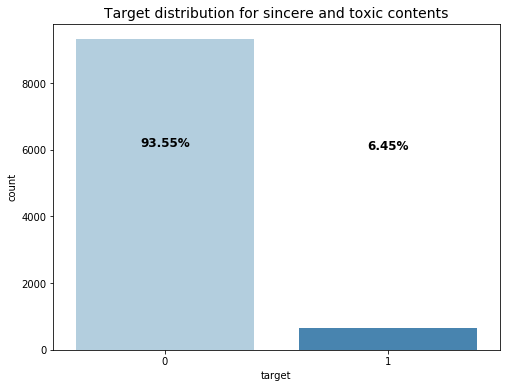

In [51]:
plt.figure(figsize=(8, 6))

#Plot the Target distributions for sincere and toxic contents
plt.title('Target distribution for sincere and toxic contents', size=14)                       #Graph title

#Countplot graph
sns.countplot(x='target',                                                                     #Data to plot : target    
              data=quora_questions,
              palette="Blues")                                                                

#Write the target percentage on top
grouped_values = (quora_questions.target.value_counts() / quora_questions.target.shape[0]) * 100          #Compute Class percentage
for label, value in enumerate(grouped_values):
    plt.text(label,                                                                           #Class index
             value + 6000,                                                                    #Class percentage position
             str(round(value,2)) + '%',                                                       #Class percentage to print
             ha="center",                                                                     #Center Class percentage label
             fontweight='bold',                                                               #Text property
             fontsize=12)                                                                     #Text property      

#Save the graph with plt.savefig
filepath_fig_quora_incinsere_distributions = os.path.join('graph', 'quora-incinsere-questions-target-distributions.jpg')
plt.savefig(filepath_fig_quora_incinsere_distributions,                                       #Image path
            format='jpg',                                                                     #Image format to save
            bbox_inches='tight')                                                              #Keep abscissa legend

plt.show()

Later, I use **oversampling** or **undersampling** method **to balance my dataset** to build Supervised Machine Learning model.

<h2> 3. Data Preparation

<h3> 3.1 Text Preprocessing

To can exploit text, I need to apply **prepocessing tasks** such as **tokenization, lemmatizaton and stemming**. 
- **Tokenization** is the process of splitting a text into words
- **Stemming** keeps only the root of the word (i.e. truncating the word)
- **Lemmatization** adds some context to get the relevant root of a word (infinitive...)

I use `Natural Language Tools Kit (NLTK)` library, it's one of **the most frequently used libraries for NLP**, especially for doing research.

In [92]:
def get_wordnet_pos(pos_tag):
    '''
    This function uses to transform POS-tagging (what type of word) to tags in Lemmatization.
    
    Parameter
    -------------
    pos_tag : str
        contains POS-tagging of a word  
    
    Returns
    -------------
    output : str
        contains wordnet (tags read by Lemmatizer)
    '''
    output = np.asarray(pos_tag)
    for i in range(len(pos_tag)):
        if pos_tag[i][1].startswith('J'):
            output[i][1] = wordnet.ADJ
        elif pos_tag[i][1].startswith('V'):
            output[i][1] = wordnet.VERB
        elif pos_tag[i][1].startswith('R'):
            output[i][1] = wordnet.ADV
        else:
            output[i][1] = wordnet.NOUN
            
    return output

For example, I choose one word and I apply `get_wordnet_pos` function :

In [24]:
#Print POS tagging of tokens
word_tagged = nltk.pos_tag(['I', 'love', 'Quora', 'website'])
word_tagged

[('I', 'PRP'), ('love', 'VBP'), ('Quora', 'NNP'), ('website', 'NN')]

In [25]:
#Apply get_wordnet_pos function
get_wordnet_pos(word_tagged)

array([['I', 'n'],
       ['love', 'v'],
       ['Quora', 'n'],
       ['website', 'n']], dtype='<U7')

I define a **preprocessing** function :

In [93]:
def preprocessing_sentence(sentence):
    '''
    This function uses for text preprocessing.
    
    Parameter
    -------------
    sentence : str
        contains text corpus
    
    Returns
    -------------
    lemmatized_sentence : list
        contains list of word tokenized after preprocessing
    '''
    #Tokenize our sentence
    tokens = word_tokenize(sentence)
    
    #Remove punctuation
    tokens = [t.lower() for t in tokens if t.isalpha()]
    
    #Remove stop words : stop words are words that typically add no value to the text
    tokens = [t for t in tokens if t not in stopwords.words("english")]
    
    #Lemmatize tokens
    words_tagged = nltk.pos_tag(tokens)
    tags = get_wordnet_pos(words_tagged)
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = [lemmatizer.lemmatize(w_t[0], pos=w_t[1]) for w_t in tags]
    
    return lemmatized_sentence

I use `apply` function in pandas to do **preprocessing** on `question_text` column :

In [94]:
quora_questions['tokens'] = quora_questions['question_text'].apply(preprocessing_sentence)

In [95]:
quora_questions.head()

,qid,question_text,target,tokens
305711,3be0cfa79beb7e5f606b,"Who would win, SSB Goku (ToP) vs Base Goku (SD...",0,"[would, win, ssb, goku, top, v, base, goku, sd..."
117952,1716ecee485d6cd0a819,Are there any organizational skills classes or...,0,"[organizational, skill, class, camp, teen]"
963395,bcc372d77a2e615351b6,If an abuser married a person he/she can’t abu...,0,"[abuser, married, person, abuse, still, abuse,..."
152315,1dcc547fdc41b1a554a0,Why didn't they accept me in the Conservatoriu...,0,"[accept, conservatorium, send, best, piano, pi..."
359783,4683c11a002d6fba5630,What is the media role in ending drunk driving?,0,"[medium, role, end, drunk, driving]"


In [96]:
#Define file path :
filepath_quora_cleaned = os.path.join('data', 'quora_questions_cleaned.pkl')

#Save quora dataset with pickle:
quora_questions.to_pickle(filepath_quora_cleaned)

<h3> 3.2 Features and labels definitions

I define `X` as **text preprocessed** column :

In [27]:
X = quora_questions['tokens']

Labels are `target`: it takes value 1 in case of incincere questions and 0 otherwise : it represents `y` 

In [28]:
y = quora_questions['target']

Previously, I constated that my dataset is unbalanced: there are more sincere questions than toxic questions.

In [29]:
y.value_counts()

0    9313
1     642
Name: target, dtype: int64

I **split** data into **train** and **test** to build model with `train_test_split` method from `Scikit-Learn` :

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2,       #train represents 80% of dataset and test represents 20% of dataset
                                                    random_state=0,     #keep the same random split
                                                    stratify=y)         #conserve the same distributions for labels

In [31]:
X_train.values

array([list(['feel', 'god', 'disapproval', 'towards', 'homosexual', 'lifestyle']),
       list(['example', 'descriptive', 'detail']),
       list(['right', 'want', 'hillary', 'jail', 'yet', 'concern', 'trump', 'equally', 'bad', 'ethical', 'discrepancy']),
       ...,
       list(['people', 'bear', 'first', 'day', 'astrological', 'sign', 'especially', 'connect', 'horoscope']),
       list(['alien', 'workshop']),
       list(['would', 'like', 'find', 'move', 'intentional', 'know', 'recommend', 'experience', 'one'])],
      dtype=object)

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7964,), (7964,), (1991,), (1991,))

In [34]:
#Define file path :
filepath_train_test_unbalanced = os.path.join('data', 'quora_questions_train_test_unbalanced.pkl')

#Save quora dataset for train and test with pickle:
with open(filepath_train_test_unbalanced, 'wb') as f:
    pickle.dump((X, y, X_train, X_test, y_train, y_test), f)

<h3> 3.2 Undersampling to improve model performance

In [56]:
#Define file path :
filepath_train_test_unbalanced = os.path.join('data', 'quora_questions_train_test_unbalanced.pkl')

#Load quora dataset for train and test:
with open(filepath_train_test_unbalanced, 'rb') as f:
    X, y, X_train, X_test, y_train, y_test = pickle.load(f)

In [51]:
#Define file path :
filepath_train_test_unbalanced = os.path.join('data', 'quora_questions_train_test_unbalanced.pkl')

#Load quora dataset for train and test:
with open(filepath_train_test_unbalanced, 'rb') as f:
    X, y, X_train, X_test, y_train, y_test = pickle.load(f)

In [52]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7964,), (7964,), (1991,), (1991,))

The dataset is highly unbalanced. I use **undersampling method** to **reduce the sincere questions part** and balance `target`: 

In [14]:
#Instanciate undersampler
undersampler = RandomUnderSampler(random_state=0)

#Instanciate oversampler
oversampler = RandomOverSampler(random_state=0)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(np.array(X_train).reshape(-1, 1),      #I reshape X_train to have this form to use RandomUnderSampler : (rows, 1)
                                                                       y_train)

In [36]:
X_train_undersampled.shape, y_train_undersampled.shape

((1028, 1), (1028,))

In [34]:
#Count toxic questions
np.count_nonzero(y_train_undersampled == 1)

514

In [35]:
#Count sincere questions
np.count_nonzero(y_train_undersampled == 0)

514

In [25]:
#Transform array into dataframe
y_train_undersampled_df = pd.DataFrame(y_train_undersampled, columns=['target'])

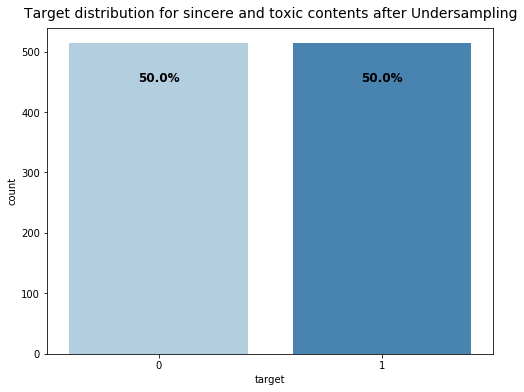

In [50]:
plt.figure(figsize=(8, 6))

#Plot the Target distributions for sincere and toxic contents after Undersampling
plt.title('Target distribution for sincere and toxic contents after Undersampling', size=14, pad=10)   

#Countplot graph
sns.countplot(x='target',                                                                     #Data to plot : target    
              data=y_train_undersampled_df,
              palette="Blues")                                                                

#Write the target percentage on top
grouped_values = (y_train_undersampled_df.target.value_counts() / y_train_undersampled_df.target.shape[0]) * 100          #Compute Class percentage
for label, value in enumerate(grouped_values):
    plt.text(label,                                                                           #Class index
             value + 400,                                                                     #Class percentage position
             str(round(value,2)) + '%',                                                       #Class percentage to print
             ha="center",                                                                     #Center Class percentage label
             fontweight='bold',                                                               #Text property
             fontsize=12)                                                                     #Text property      

#Save the graph with plt.savefig
filepath_fig_quora_incinsere_distributions_undersampled = os.path.join('graph', 'quora-incinsere-questions-target-distributions-undersampled.jpg')
plt.savefig(filepath_fig_quora_incinsere_distributions_undersampled,                          #Image path
            format='jpg',                                                                     #Image format to save
            bbox_inches='tight')                                                              #Keep abscissa legend

plt.show()

In [47]:
#Define file path :
filepath_train_test_undersampled = os.path.join('data', 'quora_questions_train_test_undersampled.pkl')

#Save data after undersampling:
with open(filepath_train_test_undersampled, 'wb') as f:
    pickle.dump((X_train_undersampled, y_train_undersampled, y_train_undersampled_df), f)

In [2]:
#Define file path :
filepath_train_test_undersampled = os.path.join('data', 'quora_questions_train_test_undersampled.pkl')

#Load data undersampled:
with open(filepath_train_test_undersampled, 'rb') as f:
    _, y_train_undersampled, _ = pickle.load(f)

<h3> 3.3 Oversampling to improve model performance

The dataset is highly unbalanced. I use **oversampling method** to **increase the sincere questions part** and balance `target`: 

In [39]:
#Instanciate oversampler
oversampler = RandomOverSampler(random_state=0)

#Balance train data
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(np.array(X_train).reshape(-1, 1),      #I reshape X_train to have this form to use RandomUnderSampler : (rows, 1)
                                                                    y_train)

In [40]:
X_train_oversampled.shape, y_train_oversampled.shape

((14900, 1), (14900,))

In [41]:
#Transform array into dataframe
y_train_oversampled_df = pd.DataFrame(y_train_oversampled, columns=['target'])

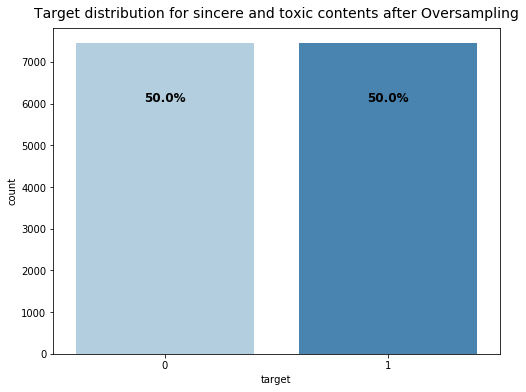

In [49]:
plt.figure(figsize=(8, 6))

#Plot the Target distributions for sincere and toxic contents after Oversampling
plt.title('Target distribution for sincere and toxic contents after Oversampling', size=14, pad=10)   

#Countplot graph
sns.countplot(x='target',                                                                     #Data to plot : target    
              data=y_train_oversampled_df,
              palette="Blues")                                                                

#Write the target percentage on top
grouped_values = (y_train_oversampled_df.target.value_counts() / y_train_oversampled_df.target.shape[0]) * 100          #Compute Class percentage
for label, value in enumerate(grouped_values):
    plt.text(label,                                                                           #Class index
             value + 6000,                                                                    #Class percentage position
             str(round(value,2)) + '%',                                                       #Class percentage to print
             ha="center",                                                                     #Center Class percentage label
             fontweight='bold',                                                               #Text property
             fontsize=12)                                                                     #Text property      

#Save the graph with plt.savefig
filepath_fig_quora_incinsere_distributions_oversampled = os.path.join('graph', 'quora-incinsere-questions-target-distributions-oversampled.jpg')
plt.savefig(filepath_fig_quora_incinsere_distributions_oversampled,                          #Image path
            format='jpg',                                                                     #Image format to save
            bbox_inches='tight')                                                              #Keep abscissa legend

plt.show()

In [48]:
#Define file path :
filepath_train_test_oversampled = os.path.join('data', 'quora_questions_train_test_oversampled.pkl')

#Save data after oversampling:
with open(filepath_train_test_oversampled, 'wb') as f:
    pickle.dump((X_train_oversampled, y_train_oversampled, y_train_oversampled_df), f)

In [4]:
#Define file path :
filepath_train_test_oversampled = os.path.join('data', 'quora_questions_train_test_oversampled.pkl')

#Load data oversampled:
with open(filepath_train_test_oversampled, 'rb') as f:
    _, y_train_oversampled, _ = pickle.load(f)

<h3> 3.4 Term Frequency - Inverse Document Frequency (TF-IDF)

Words couldn't be use with this form, I transform them into vector using **Term Frequency - Inverse Document Frequency (TF-IDF)** : it's a numerical statistic that is intended to reflect **how important a word is to a document in a collection or corpus.**

In [52]:
#Instanciate vector
vectorizer_undersampled = TfidfVectorizer(analyzer=lambda x: x)    #analyzer='word' (default) but I already do text preprocessing
vectorizer_oversampled = TfidfVectorizer(analyzer=lambda x: x)     #analyzer='word' (default) but I already do text preprocessing

In [53]:
#Compute TF-IDF for undersampling
X_train_undersampled = vectorizer_undersampled.fit_transform(X_train_undersampled.ravel()).toarray()  #ravel() : flatten array, toarray() : transform vector into array
X_test_undersampled = vectorizer_undersampled.transform(X_test).toarray()

#Compute TF-IDF for oversampling
X_train_oversampled = vectorizer_oversampled.fit_transform(X_train_oversampled.ravel()).toarray()     #ravel() : flatten array, toarray() : transform vector into array
X_test_oversampled = vectorizer_oversampled.transform(X_test).toarray()

In [62]:
X_train_undersampled.shape, X_test_undersampled.shape, X_train_oversampled.shape, X_test_oversampled.shape

((1028, 3138), (1991, 3138), (14900, 10364), (1991, 10364))

In [64]:
#Transform array into dataframe for undersampling
X_train_undersampled_df = pd.DataFrame(data= X_train_undersampled, columns=vectorizer_undersampled.get_feature_names())

#Show the first five rows of data
X_train_undersampled_df.head()

,abandon,abhay,ability,able,aboriginal,abort,abortion,absolutely,absolutes,abuse,...,youth,youtube,yugoslav,zardari,zealand,zedong,zero,zip,zone,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
#Transform array into dataframe for undersampling
X_train_oversampled_df = pd.DataFrame(data= X_train_oversampled, columns=vectorizer_oversampled.get_feature_names())

#Show the first five rows of data
X_train_oversampled_df.head()

,aaa,aadhaar,aadhar,aakash,aamir,aap,aaqib,aaron,ab,abandon,...,zoom,zuckerberg,π,гречку,юродивый,юродство,בפנים,בתוך,شغف,ओठ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4> Data save

In [66]:
#Define file path :
filepath_train_test_under_tfidf = os.path.join('data', 'quora_questions_train_test_under_tfidf.pkl')

#Save dataset after undersampling and tfidf:
with open(filepath_train_test_under_tfidf, 'wb') as f:
    pickle.dump((X_train_undersampled, X_test_undersampled, X_train_undersampled_df), f)

In [68]:
#Define file path :
filepath_train_test_over_tfidf = os.path.join('data', 'quora_questions_train_test_over_tfidf.pkl')

#Save dataset after oversampling and tfidf:
with open(filepath_train_test_over_tfidf, 'wb') as f:
    pickle.dump((X_train_oversampled, X_test_oversampled), f)

<h2> 4. Modeling : Using Supervised Machine Learning Model 💻

Logistic Regression and Random Forest are model (from `scikit-learn`) I used to predict incinsere questions.

<h3> 4.1 Logistic Regression

<h4> 4.1.1 Data undersampled 

In [5]:
#Define file path :
filepath_train_test_under_tfidf = os.path.join('data', 'quora_questions_train_test_under_tfidf.pkl')

#Save dataset after undersampling and tfidf:
with open(filepath_train_test_under_tfidf, 'rb') as f:
    X_train_undersampled, X_test_undersampled, _ = pickle.load(f)

In [9]:
#Instanciate model
lr_undersampled = LogisticRegression()

#Model fitting
lr_undersampled.fit(X_train_undersampled, y_train_undersampled)

#Model predictions
y_pred_lr_undersampled = lr_undersampled.predict(X_test_undersampled)

In [12]:
#Compute f1 score
f1_score_lr_under = f1_score(y_test, y_pred_lr_undersampled) * 100
f1_score_lr_under

33.597464342313785

**Result** : this model is not adapted for detect toxic content because `F1 score = 33.60 %` but `Recall = 83%`.

In [14]:
#Compute score
print(classification_report(y_test, y_pred_lr_undersampled))

              precision    recall  f1-score   support

           0       0.99      0.79      0.87      1863
           1       0.21      0.83      0.34       128

    accuracy                           0.79      1991
   macro avg       0.60      0.81      0.61      1991
weighted avg       0.94      0.79      0.84      1991



In [15]:
#Define file path :
filepath_lr_under = os.path.join('data', 'quora_questions_lr_under.pkl')

#Save data after undersampling and tfidf:
with open(filepath_lr_under, 'wb') as f:
    pickle.dump((y_pred_lr_undersampled, f1_score_lr_under), f)

<h4> 4.1.2 Data oversampled 

In [6]:
#Define file path :
filepath_train_test_over_tfidf = os.path.join('data', 'quora_questions_train_test_over_tfidf.pkl')

#Save dataset after oversampling and tfidf:
with open(filepath_train_test_over_tfidf, 'rb') as f:
    X_train_oversampled, X_test_oversampled = pickle.load(f)

In [16]:
#Instanciate model
lr_oversampled = LogisticRegression()

#Model fitting
lr_oversampled.fit(X_train_oversampled, y_train_oversampled)

#Model predictions
y_pred_lr_oversampled = lr_oversampled.predict(X_test_oversampled)

In [17]:
#Compute f1 score
f1_score_lr_over = f1_score(y_test, y_pred_lr_oversampled) * 100
f1_score_lr_over

40.35087719298245

**Result** : this model is not adapted for detect toxic content because `F1 score = 40.35 %`.

In [18]:
#Compute score
print(classification_report(y_test, y_pred_lr_oversampled))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1863
           1       0.32      0.54      0.40       128

    accuracy                           0.90      1991
   macro avg       0.64      0.73      0.67      1991
weighted avg       0.93      0.90      0.91      1991



In [19]:
#Define file path :
filepath_lr_over = os.path.join('data', 'quora_questions_lr_over.pkl')

#Save data after undersampling and tfidf:
with open(filepath_lr_over, 'wb') as f:
    pickle.dump((y_pred_lr_oversampled, f1_score_lr_over), f)

<h3> 4.2 Random Forest

<h4> 4.2.1 Data undersampled 

In [69]:
#Instanciate model
rf_undersampled = RandomForestClassifier()

#Model fitting
rf_undersampled.fit(X_train_undersampled, y_train_undersampled)

#Model predictions
y_pred_undersampled = rf_undersampled.predict(X_test_undersampled)

In [83]:
#Compute f1 score
f1_score_rf_under = f1_score(y_test, y_pred_undersampled) * 100
f1_score_rf_under

35.34136546184739

**Result** : this model is not adapted for detect toxic content because `F1 score = 35.34 %`.

In [73]:
#Compute score
print(classification_report(y_test, y_pred_undersampled))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1863
           1       0.24      0.69      0.35       128

    accuracy                           0.84      1991
   macro avg       0.61      0.77      0.63      1991
weighted avg       0.93      0.84      0.87      1991



<h4> Data save

In [84]:
#Define file path :
filepath_rf_under = os.path.join('data', 'quora_questions_rf_under.pkl')

#Save dataset after undersampling and tfidf:
with open(filepath_rf_under, 'wb') as f:
    pickle.dump((y_pred_undersampled, f1_score_rf_under), f)

In [89]:
#Define file path :
filepath_rf_under_model = os.path.join('data', 'quora_questions_rf_under_model.joblib')

#Save model :
dump(rf_undersampled, filepath_rf_under_model)

['../../../../../data/NLP/quora_questions_rf_under_model.joblib']

<h4> 4.2.2 Data oversampled

In [75]:
#Instanciate model
rf_oversampled = RandomForestClassifier()

#Model fitting
rf_oversampled.fit(X_train_oversampled, y_train_oversampled)

#Model predictions
y_pred_oversampled = rf_oversampled.predict(X_test_oversampled)

In [85]:
#Compute f1 score
f1_score_rf_over = f1_score(y_test, y_pred_oversampled) * 100
f1_score_rf_over

23.602484472049685

**Result** : this model is not adapted for detect toxic content because `F1 score = 23.60 %`.

In [80]:
#Compute score
print(classification_report(y_test, y_pred_oversampled))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1863
           1       0.58      0.15      0.24       128

    accuracy                           0.94      1991
   macro avg       0.76      0.57      0.60      1991
weighted avg       0.92      0.94      0.92      1991



<h4> Data save

In [86]:
#Define file path :
filepath_rf_over = os.path.join('data', 'quora_questions_rf_over.pkl')

#Save dataset after undersampling and tfidf:
with open(filepath_rf_over, 'wb') as f:
    pickle.dump((y_pred_oversampled, f1_score_rf_over), f)

In [88]:
#Define file path :
filepath_rf_over_model = os.path.join('data', 'quora_questions_rf_over_model.joblib')

#Save model :
dump(rf_oversampled, filepath_rf_over_model)

['../../../../../data/NLP/quora_questions_rf_over_model.joblib']

<h3> 4.3 Sentiment Analysis

**[Sentiment Analysis](https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17)** is the **interpretation and classification of emotions within text data** using text analysis techniques. It's based on two concepts :
1. **Polarity** in sentiment analysis refers to **identifying sentiment orientation (positive, neutral, and negative)** in written or spoken language :
    - **negative feeling** : `value = -1` (minimum)
    - **neutral feeling** : `value = 0`
    - **positive feeling** : `value = 1` (maximum)

 2. **Subjectivity** is **opinions that describe people’s feelings towards a specific subject or topic** :
    - **objective** : `value = 0` (minimum)
    - **subjective** : `value = 1` (maximum)

I **add features** with **Sentiment Analysis** to improve performance of model by using `TextBlob` library, a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

In [2]:
#Define file path :
filepath_quora_cleaned = os.path.join('data', 'quora_questions_cleaned.pkl')

#Load quora dataset:
quora_questions = pd.read_pickle(filepath_quora_cleaned)

In [3]:
quora_questions.head()

,qid,question_text,target,tokens
305711,3be0cfa79beb7e5f606b,"Who would win, SSB Goku (ToP) vs Base Goku (SD...",0,"[would, win, ssb, goku, top, v, base, goku, sd..."
117952,1716ecee485d6cd0a819,Are there any organizational skills classes or...,0,"[organizational, skill, class, camp, teen]"
963395,bcc372d77a2e615351b6,If an abuser married a person he/she can’t abu...,0,"[abuser, married, person, abuse, still, abuse,..."
152315,1dcc547fdc41b1a554a0,Why didn't they accept me in the Conservatoriu...,0,"[accept, conservatorium, send, best, piano, pi..."
359783,4683c11a002d6fba5630,What is the media role in ending drunk driving?,0,"[medium, role, end, drunk, driving]"


In [4]:
#Compute polarity for one list of tokens
[TextBlob(word).sentiment.polarity for word in quora_questions['tokens'][305711]]

[0.0, 0.8, 0.0, 0.0, 0.5, 0.0, -0.8, 0.0, 0.0, 0.0]

In [10]:
#Compute mean of polarity for one list of tokens
np.mean([TextBlob(word).sentiment.polarity for word in quora_questions['tokens'][305711]])

0.05

In [19]:
def get_polarity_mean(tokens):
    '''
    This function computes polarity mean of tokens.
    
    Parameter
    -------------
    tokens : list of str
        contains tokens
    
    Returns
    -------------
    polarity : float
        contains polarity mean of tokens
    '''
    #Replace polarity of tokens empty list by 0 (neutral)
    if len(tokens) == 0:
        return 0
    
    return np.mean([TextBlob(word).sentiment.polarity for word in tokens])

In [20]:
#Compute get_polarity_mean function
quora_questions['polarity'] = quora_questions['tokens'].apply(get_polarity_mean)

In [21]:
quora_questions.head()

,qid,question_text,target,tokens,polarity
305711,3be0cfa79beb7e5f606b,"Who would win, SSB Goku (ToP) vs Base Goku (SD...",0,"[would, win, ssb, goku, top, v, base, goku, sd...",0.050000
117952,1716ecee485d6cd0a819,Are there any organizational skills classes or...,0,"[organizational, skill, class, camp, teen]",0.000000
963395,bcc372d77a2e615351b6,If an abuser married a person he/she can’t abu...,0,"[abuser, married, person, abuse, still, abuse,...",0.035714
152315,1dcc547fdc41b1a554a0,Why didn't they accept me in the Conservatoriu...,0,"[accept, conservatorium, send, best, piano, pi...",0.109091
359783,4683c11a002d6fba5630,What is the media role in ending drunk driving?,0,"[medium, role, end, drunk, driving]",-0.100000


In [22]:
#Number of null values
quora_questions.isna().sum()

qid              0
question_text    0
target           0
tokens           0
polarity         0
dtype: int64

In [26]:
def get_subjectivity_mean(tokens):
    '''
    This function computes subjectivity mean of tokens.
    
    Parameter
    -------------
    tokens : list of str
        contains tokens
    
    Returns
    -------------
    subjectivity : float
        contains subjectivity mean of tokens
    '''
    #Replace subjectivity of tokens empty list by 0 (neutral)
    if len(tokens) == 0:
        return 0
    
    return np.mean([TextBlob(word).sentiment.subjectivity for word in tokens])

In [27]:
#Compute get_subjectivity_mean function
quora_questions['subjectivity'] = quora_questions['tokens'].apply(get_subjectivity_mean)

In [28]:
quora_questions.head()

,qid,question_text,target,tokens,polarity,subjectivity
305711,3be0cfa79beb7e5f606b,"Who would win, SSB Goku (ToP) vs Base Goku (SD...",0,"[would, win, ssb, goku, top, v, base, goku, sd...",0.050000,0.190000
117952,1716ecee485d6cd0a819,Are there any organizational skills classes or...,0,"[organizational, skill, class, camp, teen]",0.000000,0.000000
963395,bcc372d77a2e615351b6,If an abuser married a person he/she can’t abu...,0,"[abuser, married, person, abuse, still, abuse,...",0.035714,0.035714
152315,1dcc547fdc41b1a554a0,Why didn't they accept me in the Conservatoriu...,0,"[accept, conservatorium, send, best, piano, pi...",0.109091,0.081818
359783,4683c11a002d6fba5630,What is the media role in ending drunk driving?,0,"[medium, role, end, drunk, driving]",-0.100000,0.200000


In [30]:
#Number of null values
quora_questions.isna().sum()

qid              0
question_text    0
target           0
tokens           0
polarity         0
subjectivity     0
dtype: int64

<h4> Data Save

In [32]:
#Define file path :
filepath_quora_sub_pol = os.path.join('data', 'quora_questions_pol_sub.pkl')

#Save quora dataset with pickle:
quora_questions.to_pickle(filepath_quora_sub_pol)

In [30]:
#Define file path :
filepath_quora_sub_pol = os.path.join('data', 'quora_questions_pol_sub.pkl')

#Load quora dataset:
quora_questions = pd.read_pickle(filepath_quora_sub_pol)

<h4> Data Analysis

I display some **statistical summaries of the numerical columns** below :
- `Polarity`:
    - mean = 0.021
    - min = -0.50
    - max = 0.50
    - standard déviation : 0.08

`Polarity` distribution is higher around the average because `standard_deviation > 0.5 * mean`

- `Subjectivity`:
    - mean = 0.07
    - min = 0
    - max = 1
    - standard déviation : 0.09

`Subjectivity` distribution is higher around the average because `standard_deviation > 0.5 * mean`

In [31]:
#Statistical summaries of the numerical columns
quora_questions.describe()

,target,polarity,subjectivity
count,9955.000000,9955.000000,9955.000000
mean,0.064490,0.021156,0.066771
std,0.245636,0.076690,0.091214
min,0.000000,-0.500000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.025000
75%,0.000000,0.033333,0.110000
max,1.000000,0.500000,1.000000


In [32]:
quora_questions.target.value_counts()

0    9313
1     642
Name: target, dtype: int64

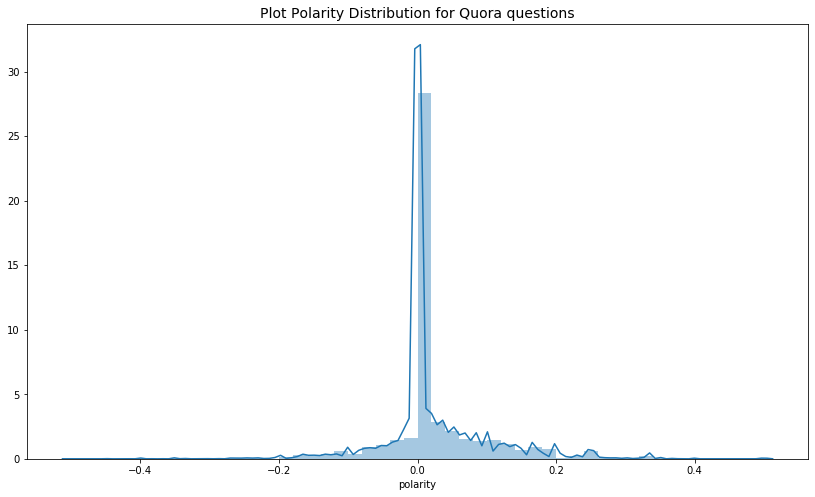

In [48]:
plt.figure(figsize=(14, 8))

#Plot Polarity Distribution for Quora questions
plt.title('Plot Polarity Distribution for Quora questions', size=14)       #Graph title

#Countplot for Polarity
sns.distplot(quora_questions.polarity)

#Save the graph with plt.savefig
filepath_fig_polarity_distributions = os.path.join('graph', 'quora-incinsere-questions-polarity-distributions.jpg')
plt.savefig(filepath_fig_polarity_distributions,                   #Image path
            format='jpg',                                                 #Image format to save
            bbox_inches='tight')                                          #Keep abscissa legend

plt.show()

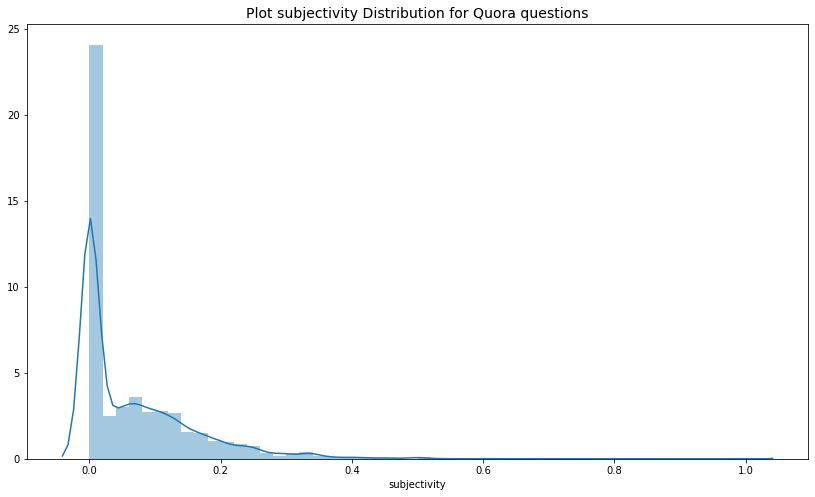

In [47]:
plt.figure(figsize=(14, 8))

#Plot subjectivity Distribution for Quora questions
plt.title('Plot subjectivity Distribution for Quora questions', size=14)       #Graph title

#Countplot for subjectivity
sns.distplot(quora_questions.subjectivity)

#Save the graph with plt.savefig
filepath_fig_subjectivity_distributions = os.path.join('graph', 'quora-incinsere-questions-subjectivity-distributions.jpg')
plt.savefig(filepath_fig_subjectivity_distributions,                          #Image path
            format='jpg',                                                     #Image format to save
            bbox_inches='tight')                                              #Keep abscissa legend

plt.show()

I compare `polarity` with `target` to icompute a `confusion matrix` :

In [28]:
#Number of good review
nb_good_questions = quora_questions.target.value_counts()[0]

#Number of bad review
nb_bad_questions = quora_questions.target.value_counts()[1]

In [45]:
quora_questions[quora_questions.polarity > 0].shape[0] / quora_questions.shape[0] * 100

33.87242591662481

In [46]:
quora_questions[quora_questions.polarity < 0].shape[0] / quora_questions.shape[0] * 100

14.475138121546962

In [29]:
#Compute confusion matrix for polarity
True_good = quora_questions[quora_questions.polarity > 0][quora_questions.target == 0].shape[0]
print("Polarity positive AND classified as good questions: ", 100 * round(True_good/nb_good_questions, 2), "%")

False_good = quora_questions[quora_questions.polarity < 0][quora_questions.target == 0].shape[0]
print("Polarity negative BUT classified as good questions: ", 100 * round(False_good/nb_good_questions, 2), "%")

True_bad = quora_questions[quora_questions.polarity < 0][quora_questions.target == 1].shape[0]
print("Polarity negative AND classified as bad questions: ", 100 * round(True_bad/nb_bad_questions, 2), "%")

False_bad = quora_questions[quora_questions.polarity > 0][quora_questions.target == 1].shape[0]
print("Polarity positive BUT classified as bad questions: ", 100 * round(False_bad/nb_bad_questions, 1), "%")

Polarity positive AND classified as good questions:  34.0 %
Polarity negative BUT classified as good questions:  14.000000000000002 %
Polarity negative AND classified as bad questions:  28.000000000000004 %
Polarity positive BUT classified as bad questions:  30.0 %


/home/jlenclume/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/jlenclume/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jlenclume/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/jlenclume/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


I plot `polarity`, `subjectivity` and `target` to analyze new features :

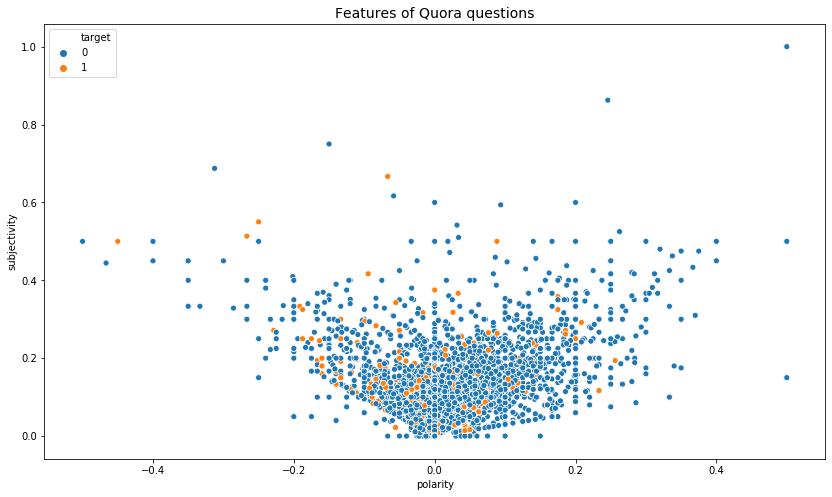

In [49]:
plt.figure(figsize=(14, 8))

#Plot subjectivity, polarity and target
plt.title('Features of Quora questions', fontsize=14)                                   #Graph title
sns.scatterplot(x='polarity', y='subjectivity', hue='target', data=quora_questions)

#Save the graph with plt.savefig
filepath_fig_sub_pol_target = os.path.join('graph', 'quora-incinsere-questions-target-pol-sub.jpg')
plt.savefig(filepath_fig_sub_pol_target,                                                #Image path
            format='jpg',                                                               #Image format to save
            bbox_inches='tight')                                                        #Keep abscissa legend

plt.show()

Correlation matrix graphically gives us an idea of how features correlate with each other and can help us predict what are the features that are most relevant for the prediction :

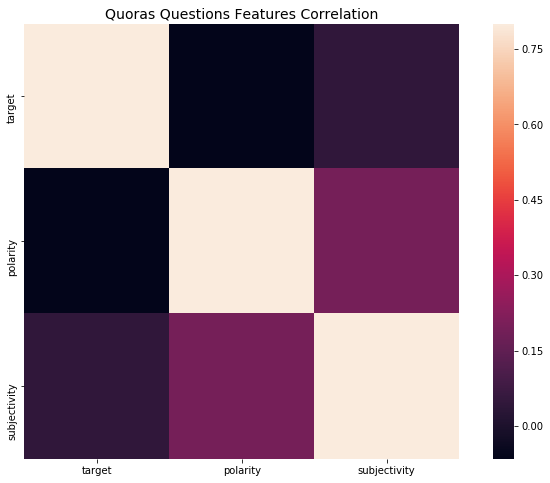

In [50]:
#Compute correlation matrix
correlation_matrix = quora_questions.corr()

#Plot correlation matrix with heatmap
fig = plt.figure(figsize = (12, 8))
plt.title('Quoras Questions Features Correlation', size=14)            #Graph title
sns.heatmap(correlation_matrix, vmax = .8, square = True)

#Save the graph with plt.savefig
filepath_fig_correlation = os.path.join('graph', 'quora-incinsere-questions-correlation-heatmap.jpg')
plt.savefig(filepath_fig_correlation,                                 #Image path
            format='jpg',                                             #Image format to save
            bbox_inches='tight')                                      #Keep abscissa legend

plt.show()

I can clearly see that all features **don't correlate**.

<h3> 4.4 Features and labels definitions

In [53]:
X = quora_questions[['tokens', 'polarity', 'subjectivity']]
y = quora_questions['target']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2,       #train represents 80% of dataset and test represents 20% of dataset
                                                    random_state=0,     #keep the same random split
                                                    stratify=y)         #conserve the same distributions for labels

In [55]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7964, 3), (7964,), (1991, 3), (1991,))

In [58]:
X_train.tokens

742476     [feel, god, disapproval, towards, homosexual, ...
5028                          [example, descriptive, detail]
992223     [right, want, hillary, jail, yet, concern, tru...
1232215        [movie, question, existence, help, get, life]
972354     [british, people, obsess, east, asian, culture...
                                 ...                        
364200     [someone, ever, return, favor, parent, upbring...
753441     [prospect, cfa, charter, holder, germany, year...
835910     [people, bear, first, day, astrological, sign,...
414064                                     [alien, workshop]
1193332    [would, like, find, move, intentional, know, r...
Name: tokens, Length: 7964, dtype: object

<h4> Data undersampled

In [113]:
#Instanciate undersampler
undersampler = RandomUnderSampler(random_state=0)

#Instanciate oversampler
oversampler = RandomOverSampler(random_state=0)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [114]:
X_train_undersampled.shape, y_train_undersampled.shape

((1028, 3), (1028,))

<h4> Data oversampled

In [115]:
#Instanciate oversampler
oversampler = RandomOverSampler(random_state=0)

#Balance train data
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

In [116]:
X_train_oversampled.shape, y_train_oversampled.shape

((14900, 3), (14900,))

<h4> TF-IDF

In [117]:
#Instanciate vector
vectorizer_undersampled = TfidfVectorizer(analyzer=lambda x: x)    #analyzer='word' (default) but I already do text preprocessing
vectorizer_oversampled = TfidfVectorizer(analyzer=lambda x: x)     #analyzer='word' (default) but I already do text preprocessing

In [131]:
#Compute TF-IDF for undersampling
tfidf_train_under = vectorizer_undersampled.fit_transform(X_train_undersampled.tokens).toarray()
tfidf_test_under = vectorizer_undersampled.transform(X_test_undersampled.tokens).toarray()

#Compute TF-IDF for oversampling
tfidf_train_over = vectorizer_oversampled.fit_transform(X_train_oversampled.tokens).toarray()
tfidf_test_over = vectorizer_oversampled.transform(X_test_oversampled.tokens).toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'tokens'

In [129]:
#Transform Series into array for undersampling
X_train_undersampled.polarity = np.array(X_train_undersampled.polarity)
X_train_undersampled.subjectivity = np.array(X_train_undersampled.subjectivity)

#Transform Series into array for undersampling
X_train_oversampled.polarity = np.array(X_train_oversampled.polarity)
X_train_oversampled.subjectivity = np.array(X_train_oversampled.subjectivity)

In [130]:
X_train_undersampled.polarity

0       0.054167
1       0.100000
2       0.000000
3       0.000000
4       0.000000
          ...   
1023    0.017857
1024    0.000000
1025    0.059476
1026    0.000000
1027    0.000000
Name: polarity, Length: 1028, dtype: float64

In [105]:
#Compute TF-IDF for undersampling
X_train_undersampled = np.concatenate(tfidf_train_under, 
                                      X_train_undersampled.polarity, 
                                      X_train_undersampled.subjectivity)  
X_test_undersampled = np.concatenate(tfidf_test_under, 
                                     X_train_undersampled.polarity, 
                                     X_train_undersampled.subjectivity)

#Compute TF-IDF for oversampling
X_train_oversampled = np.concatenate(tfidf_train_over, 
                                     X_train_undersampled.polarity, 
                                     X_train_undersampled.subjectivity)
X_test_oversampled = np.concatenate(tfidf_test_over, 
                                    X_train_undersampled.polarity, 
                                    X_train_undersampled.subjectivity)

TypeError: 'Series' object cannot be interpreted as an integer

In [70]:
X_train_undersampled.shape, X_test_undersampled.shape, X_train_oversampled.shape, X_test_oversampled.shape

((3, 17), (3, 17), (3, 17), (3, 17))

<h3> 4.5 Word Embeddings

Word Embeddings are a type of word representation that allows words with similar meaning to have a similar representation : Vector coordinates are assigned to each word. `Glove` is a library I used for Word Embeddings.

In [30]:
#Define file path :
filepath_quora_sub_pol = os.path.join('..', '..', '..', '..', '..', 'data', 'NLP','quora_questions_pol_sub.pkl')

#Load quora dataset:
quora_questions = pd.read_pickle(filepath_quora_sub_pol)

In [24]:
#Define file path
glove_file = os.path.join('..', '..', '..', '..', '..', 'data', 'NLP','glove.6B.50d.txt')

In [17]:
dict_line = get_dictionary(glove_files)

In [19]:
dict_line[0]

'the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581'

In [44]:
def read_glove_vecs(glove_file):
    
    with open(glove_file, 'r') as f:
        words = []
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.append(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    
    print(len(words), 'words are in glove dictionary.')
    return words, word_to_vec_map

In [45]:
words, word_to_vec_map = read_glove_vecs(glove_file)

400000 words are in glove dictionary.


In [34]:
 word_to_vec_map['would']

array([ 0.7619   , -0.29773  ,  0.51396  , -0.13303  ,  0.24156  ,
        0.066799 , -0.54084  ,  0.2071   , -0.28225  , -0.11638  ,
        0.21666  ,  0.54908  , -0.36744  , -0.10543  ,  0.81567  ,
        1.1743   ,  0.56055  , -0.3345   ,  0.099767 , -0.87465  ,
        0.12229  , -0.18532  ,  0.086783 , -0.36343  ,  0.008002 ,
       -2.2268   , -0.20079  , -0.10313  ,  0.24318  , -0.39819  ,
        3.7136   ,  0.59088  , -1.1013   , -0.25292  ,  0.0057067,
       -0.60475  ,  0.35965  , -0.059581 , -0.029059 , -0.3989   ,
       -0.52631  ,  0.12436  ,  0.13609  ,  0.12699  , -0.23032  ,
       -0.044567 , -0.6545   ,  0.43088  , -0.22768  ,  0.4026   ])

In [42]:
def is_in_vocab(tokens_list):
    in_vocab = {}
    out_vocab = {}
    for tokens in tokens_list:
        if tokens.lower() in words:
            in_vocab[tokens] = 1
        elif w in out_vocab.keys():
            out_vocab[tokens] += 1
        else:
            out_vocab[tokens] = 1
    
    out_vocab_ordered = sorted(out_vocab.items(), key=operator.itemgetter(1))[::-1]
    return in_vocab, out_vocab_ordered

In [36]:
quora_questions.iloc[1, 3]

['organizational', 'skill', 'class', 'camp', 'teen']

In [46]:
in_vocab, out_vocab_ordered = is_in_vocab(quora_questions.iloc[1, 3])

In [48]:
out_vocab_ordered

[]

## Topic Modeling

I identify the most recurrent topics in toxic questions.

## Go further

- Use Spacy library
- Implement Deep Learning model to detect fraudulent transactions

## Acknowledgments

- Python
- Natural Language Processing
    - NLTK
- Text Processing
- Sentiment Analysis : 
    - TextBlob
- Word Embedding :
    - Glove